<a href="https://colab.research.google.com/github/XiangLi368/SkinAndEyeAIModel/blob/main/eye_damage_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eye Damage Detection Model Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Enabling and testing the TPU

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 23 08:55:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |    471MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## import

In [ ]:
import re
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tqdm import tqdm

## Set configurations and read metadata

In [ ]:
#unzip file
!unzip "/content/drive/MyDrive/5703File/DataSet/ODIR-5K.zip" -d "/content"
!unzip "/content/drive/MyDrive/5703File/DataSet/cataract.zip" -d "/content"
!unrar x -r "/content/drive/MyDrive/DDR_dataset/*.rar" "/content"

In [ ]:
# !unzip "/content/drive/MyDrive/5703File/DataSet/DDR_dataset/DDR-dataset.zip.001.zip" -d "/content"

In [ ]:
# cataract dataset
IMG_ROOT = '/content/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal',
           IMG_ROOT+'2_cataract',
           IMG_ROOT+'2_glaucoma',
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = '/content/ODIR-5K/Training Images/'
ocu_df = pd.read_csv('/content/ODIR-5K/full_df.csv')

In [ ]:
# restore the data


### use PyDrive

In [ ]:
SEED = 42
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Process Cataract dataset

In [ ]:
cat_df = pd.DataFrame(0,
                  columns=['paths',
                           'disease'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]

    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3

# only sample normal and cataract and other disease
cat_df = cat_df.query('0 <= disease < 2 or disease == 3')
# cat_df = cat_df.query('disease == 3')
cat_df

# can

In [ ]:
print('Number of normal(0) and cataract(1) and other_disease(3) images')
print(cat_df['disease'].value_counts())

Number of normal(0) and cataract(1) and other_disease(3) images
0    300
3    100
1    100
Name: disease, dtype: int64


## Process Ocular Disease Dataset

In [ ]:
ocu_df.head()
# I only need filename and lables
# N-normal-0, C-cataract-1, A-AMD-4, D,G,H,M,O-Others-3

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
ocu_df.shape

(6392, 19)

In [ ]:
new_ocu_df = ocu_df.loc[:,['filename','labels']]
new_ocu_df.columns = ['paths','disease']

In [ ]:
new_ocu_df

In [ ]:
def change_label(text):
    if 'N' in text:
        return 0
    if 'C' in text:
        return 1
    if 'A' in text:
        return 2
    if 'D' in text:
        return 3
    if 'G' in text:
        return 4
    if 'H' in text:
        return 5
    if 'M' in text:
        return 6
    if 'O' in text:
        return 7

def add_filepath(text):
    str = OCU_IMG_ROOT + text
    return str
new_ocu_df['paths'] = new_ocu_df['paths'].apply(lambda x : add_filepath(x))
new_ocu_df['disease'] = new_ocu_df['disease'].apply(lambda x : change_label(x))
new_ocu_df['disease'] = new_ocu_df['disease'].astype(int)

In [ ]:
new_ocu_df

In [ ]:
print('Number of normal(0) and cataract(1) and A(2) and G(4) images')
print(new_ocu_df['disease'].value_counts())

Number of normal(0) and cataract(1) and A(2) and G(4) images
0    2873
3    1608
7     708
1     293
4     284
2     266
6     232
5     128
Name: disease, dtype: int64


down sample


In [ ]:
def downsample(df):
    df = pd.concat([
        df.query('disease==1'),
        df.query('disease==2'),
        # df.query('disease==4'),
        df.query('disease==0').sample(300,random_state=SEED)
        # df.query('disease==3').sample(300,random_state=SEED)
    ])
    return df

new_ocu_df = downsample(new_ocu_df)

print('Number of normal(0) and cataract(1) and other_disease(3) and AMD(4) and G(5) images')
print(new_ocu_df['disease'].value_counts())

Number of normal(0) and cataract(1) and other_disease(3) and AMD(4) and G(5) images
0    300
1    293
2    266
Name: disease, dtype: int64


## Create datasets

In [ ]:
df = pd.concat([cat_df, new_ocu_df], ignore_index=True)
# df = cat_df
df
print(df['disease'].value_counts())

0    600
1    393
2    266
3    100
Name: disease, dtype: int64


In [ ]:
#for transfer learning test
df1, df2 = train_test_split(df,
                        test_size=0.5,
                        random_state=SEED,
                        stratify=df['disease'])
print(df1['disease'].value_counts())
print(df2['disease'].value_counts())

0    300
1    196
2    133
3     50
Name: disease, dtype: int64
0    300
1    197
2    133
3     50
Name: disease, dtype: int64


In [ ]:
df

In [ ]:
train_df_1, test_df_1 = train_test_split(df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df['disease'])

train_df_1, val_df_1 = train_test_split(train_df_1,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df_1['disease'])

In [ ]:
#for transfer learning first half data
train_df_1_tran, test_df_1_tran = train_test_split(df1,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df1['disease'])

train_df_1_tran, val_df_1_tran = train_test_split(train_df_1_tran,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df_1_tran['disease'])

In [ ]:
#for transfer learning second half data
train_df_2_tran, test_df_2_tran = train_test_split(df2,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df2['disease'])

train_df_2_tran, val_df_2_tran = train_test_split(train_df_2_tran,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df_2_tran['disease'])

In [ ]:
print(val_df_2_tran.value_counts())

paths                                             disease
/content/dataset/3_retina_disease/Retina_097.png  3          1
/content/ODIR-5K/Training Images/2179_right.jpg   1          1
/content/ODIR-5K/Training Images/2181_left.jpg    1          1
/content/ODIR-5K/Training Images/2198_left.jpg    1          1
/content/ODIR-5K/Training Images/2200_left.jpg    1          1
                                                            ..
/content/dataset/1_normal/NL_023.png              0          1
/content/dataset/1_normal/NL_065.png              0          1
/content/dataset/1_normal/NL_066.png              0          1
/content/dataset/1_normal/NL_088.png              0          1
/content/ODIR-5K/Training Images/102_left.jpg     2          1
Length: 82, dtype: int64


In [ ]:
test_df_1

,paths,disease
704,/content/ODIR-5K/Training Images/2125_left.jpg,1
691,/content/ODIR-5K/Training Images/2108_left.jpg,1
391,/content/dataset/1_normal/NL_028.png,0
50,/content/dataset/3_retina_disease/Retina_098.png,3
521,/content/ODIR-5K/Training Images/1454_right.jpg,1
...,...,...
36,/content/dataset/3_retina_disease/Retina_002.png,3
1218,/content/ODIR-5K/Training Images/3171_left.jpg,0
1057,/content/ODIR-5K/Training Images/2053_left.jpg,2
473,/content/dataset/1_normal/NL_123.png,0


## image size

In [ ]:
# #1 size
# IMG_HEIGHT = 192
# IMG_WIDTH = 256
# #2 size
# IMG_HEIGHT = 288
# IMG_WIDTH = 384
# 3 size
IMG_HEIGHT = 400
IMG_WIDTH = 400

In [ ]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # change the img to square
        height = img.shape[0]
        width = img.shape[1]
        img = img[0:height,int((width-height)/2):int((width-(width-height)/2))]
        #
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)

    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['disease'])
    return imgs, df

#whole datasets
train_imgs, train_df = create_datasets(train_df_1, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df_1, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df_1, IMG_WIDTH, IMG_HEIGHT)

# #first datasets
# train_imgs_1_tran, train_df_1_tran = create_datasets(train_df_1_tran, IMG_WIDTH, IMG_HEIGHT)
# val_imgs_1_tran, val_df_1_tran = create_datasets(val_df_1_tran, IMG_WIDTH, IMG_HEIGHT)
# test_imgs_1_tran, test_df_1_tran = create_datasets(test_df_1_tran, IMG_WIDTH, IMG_HEIGHT)
# #second datasets
# train_imgs_2_tran, train_df_2_tran = create_datasets(train_df_2_tran, IMG_WIDTH, IMG_HEIGHT)
# val_imgs_2_tran, val_df_2_tran = create_datasets(val_df_2_tran, IMG_WIDTH, IMG_HEIGHT)
# test_imgs_2_tran, test_df_2_tran = create_datasets(test_df_2_tran, IMG_WIDTH, IMG_HEIGHT)


100%|██████████| 272/272 [00:15<00:00, 17.39it/s]


In [ ]:
train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

# train_imgs_1_tran = train_imgs_1_tran / 255.0
# val_imgs_1_tran = val_imgs_1_tran / 255.0
# test_imgs_1_tran = test_imgs_1_tran / 255.0

# train_imgs_2_tran = train_imgs_2_tran / 255.0
# val_imgs_2_tran = val_imgs_2_tran / 255.0
# test_imgs_2_tran = test_imgs_2_tran / 255.0

## Epochs and batch size

In [ ]:
EPOCHS = 100
BATCH_SIZE = 8

## Build the model (Xception)

In [ ]:
# Xception = tf.keras.applications.Xception(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], weights='imagenet', include_top=False)
# Xception.summary()

In [ ]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], weights='imagenet', include_top=False)
  pretrained_model.trainable = True
#   pretrained_model.trainable = False
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_Xception = create_model()
model_Xception.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 13, 13, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')



es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
115/115 [==============================] - 35s 260ms/step - loss: 1.0146 - accuracy: 0.6143 - val_loss: 5.1684 - val_accuracy: 0.6341
Epoch 2/100
115/115 [==============================] - 28s 244ms/step - loss: 0.8316 - accuracy: 0.6836 - val_loss: 2.2037 - val_accuracy: 0.7378
Epoch 3/100
115/115 [==============================] - 28s 241ms/step - loss: 0.6996 - accuracy: 0.7194 - val_loss: 4.9171 - val_accuracy: 0.6341
Epoch 4/100
115/115 [==============================] - 28s 242ms/step - loss: 0.6283 - accuracy: 0.7595 - val_loss: 4.4191 - val_accuracy: 0.4878
Epoch 5/100
115/115 [==============================] - 28s 242ms/step - loss: 0.5546 - accuracy: 0.7768 - val_loss: 0.7979 - val_accuracy: 0.8049
Epoch 6/100
115/115 [==============================] - 28s 244ms/step - loss: 0.5035 - accuracy: 0.8223 - val_loss: 0.7991 - val_accuracy: 0.7317
Epoch 7/100
115/115 [==============================] - 28s 243ms/step - loss: 0.4737 - accuracy: 0.8462 - val_loss: 0.7165 -

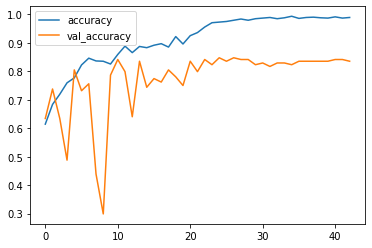

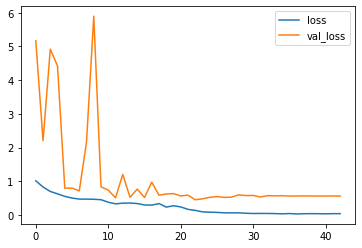

In [ ]:
history = model_Xception.fit(generator.flow(train_imgs,
                                   train_df,
                                   batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
# model_Xception.evaluate(test_imgs_1_tran, test_df_1_tran)

In [ ]:
# model_Xception.evaluate(test_imgs_2_tran, test_df_2_tran)

In [ ]:
model_Xception.evaluate(test_imgs, test_df)

9/9 [==============================] - 1s 163ms/step - loss: 0.5026 - accuracy: 0.8419


[0.5026144981384277, 0.841911792755127]

In [ ]:
predictions = model_Xception.predict(test_imgs, steps=len(test_df), verbose=1)
y_pred = np.argmax(predictions, axis=1)

272/272 [==============================] - 3s 8ms/step


In [ ]:
y_true = test_df_1['disease'].tolist()

from sklearn.metrics import classification_report, f1_score


In [ ]:
f1_score(y_true, y_pred, average='weighted')

0.8409886604347928

In [ ]:
plot_labels = ['N','C','A','O']
report = classification_report(y_true, y_pred, target_names=plot_labels)

print('report')
print(report)

report
              precision    recall  f1-score   support

           N       0.86      0.79      0.83       120
           C       0.81      0.97      0.89        79
           A       0.93      0.81      0.87        53
           O       0.67      0.70      0.68        20

    accuracy                           0.84       272
   macro avg       0.82      0.82      0.82       272
weighted avg       0.85      0.84      0.84       272



In [ ]:
#300 -- 85.7
#400 -- 86 acc
#300 5 class -- 83 acc
#300 4 class 24 batch size -- 84 acc
#300 4 class 48 batch size -- 87 acc
#300 4 class 16 batch size -- 84.2 acc

#400 4 class 16 batch size -- 86.0 acc

#400 4 class 48 batch size -- 86.6 acc

#400 4 class 8 batch size -- 0.8308823704719543 acc

## transfer learning test

In [ ]:
model_Xception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
def create_model_tran():
  pretrained_model = model_Xception
  pretrained_model.trainable = True
#   pretrained_model.trainable = False
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_Xception_2 = create_model()
model_Xception_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')



es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
14/14 [==============================] - 12s 552ms/step - loss: 0.9689 - accuracy: 0.6190 - val_loss: 18.1484 - val_accuracy: 0.3171
Epoch 2/100
14/14 [==============================] - 7s 465ms/step - loss: 0.6574 - accuracy: 0.7532 - val_loss: 5.1927 - val_accuracy: 0.4878
Epoch 3/100
14/14 [==============================] - 7s 464ms/step - loss: 0.4583 - accuracy: 0.8377 - val_loss: 2.1913 - val_accuracy: 0.7073
Epoch 4/100
14/14 [==============================] - 7s 465ms/step - loss: 0.5056 - accuracy: 0.8420 - val_loss: 1.8850 - val_accuracy: 0.6098
Epoch 5/100
14/14 [==============================] - 7s 464ms/step - loss: 0.4809 - accuracy: 0.8225 - val_loss: 2.5072 - val_accuracy: 0.5000
Epoch 6/100
14/14 [==============================] - 7s 467ms/step - loss: 0.2694 - accuracy: 0.9134 - val_loss: 2.8807 - val_accuracy: 0.5976
Epoch 7/100
14/14 [==============================] - 7s 465ms/step - loss: 0.3058 - accuracy: 0.9004 - val_loss: 2.3845 - val_accuracy: 0.76

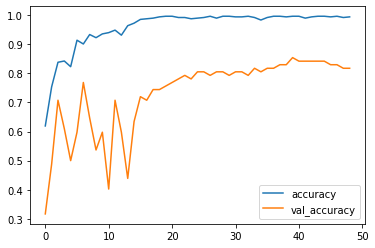

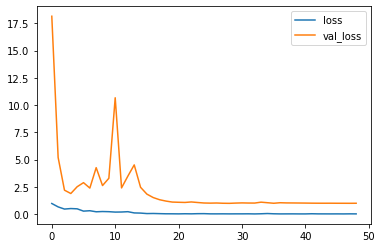

In [ ]:
history = model_Xception_2.fit(generator.flow(train_imgs_2_tran,
                                   train_df_2_tran,
                                   batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs_2_tran)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs_2_tran, val_df_2_tran))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model_Xception_2.evaluate(test_imgs_1_tran, test_df_1_tran)

5/5 [==============================] - 0s 66ms/step - loss: 0.9976 - accuracy: 0.8235


[0.9976334571838379, 0.8235294222831726]

In [ ]:
model_Xception_2.evaluate(test_imgs_2_tran, test_df_2_tran)

5/5 [==============================] - 0s 66ms/step - loss: 0.9381 - accuracy: 0.8015


[0.9380587935447693, 0.8014705777168274]

In [ ]:
predictions = model_Xception_2.predict(test_imgs, steps=len(test_df), verbose=1)
y_pred = np.argmax(predictions, axis=1)

272/272 [==============================] - 2s 7ms/step


In [ ]:
y_true = test_df_1['disease'].tolist()

from sklearn.metrics import classification_report, f1_score

In [ ]:
f1_score(y_true, y_pred, average='weighted')

0.9320680291308412

In [ ]:
plot_labels = ['N','C','A','O']
report = classification_report(y_true, y_pred, target_names=plot_labels)

print('report')
print(report)

report
              precision    recall  f1-score   support

           N       0.91      0.97      0.94       120
           C       0.93      0.99      0.96        79
           A       1.00      0.85      0.92        53
           O       1.00      0.70      0.82        20

    accuracy                           0.93       272
   macro avg       0.96      0.88      0.91       272
weighted avg       0.94      0.93      0.93       272



## Save the model

In [ ]:
model_Xception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


## Build the model (EfficientNetB0)

In [ ]:
!pip install -q efficientnet >> /dev/null
import efficientnet.tfkeras as efn

def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n),
        weights='imagenet',
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model_Efficient = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model_Efficient.summary()

16818176/16804768 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5124      
Total params: 4,054,688
Trainable params: 4,012,672
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')



es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [ ]:
history = model_Efficient.fit(generator.flow(train_imgs,
                                   train_df,
                                   batch_size=BATCH_SIZE),
                    epochs=1000,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model_Efficient.evaluate(test_imgs, test_df)

In [ ]:
predictions = model_Efficient.predict(test_imgs, steps=len(test_df), verbose=1)
y_pred = np.argmax(predictions, axis=1)

y_true = test_df_1['disease'].tolist()

from sklearn.metrics import classification_report, f1_score

f1_score(y_true, y_pred, average='weighted')

In [ ]:
#300 B3 83.5
#400 B0 72.8
#400 B0 4 class 48 batch size -- 80.8 acc
#400 B0 4 class 8 batch size -- 0.845588207244873 acc 0.6309579109532658 f1

## Build model(resNet50)

In [ ]:
def create_model():
  pretrained_model = tf.keras.applications.ResNet50(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_resnet50 = create_model()
model_resnet50.summary()

In [ ]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')



es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [ ]:
history = model_resnet50.fit(generator.flow(train_imgs,
                                   train_df,
                                   batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model_resnet50.evaluate(test_imgs, test_df)

In [ ]:
predictions = model_resnet50.predict(test_imgs, steps=len(test_df), verbose=1)
y_pred = np.argmax(predictions, axis=1)

y_true = test_df_1['disease'].tolist()

from sklearn.metrics import classification_report, f1_score

f1_score(y_true, y_pred, average='weighted')